### Model Tuning and Evaluation (2008)
This notebook follows the same process detailed in Model Tuning and Evaluation (2012), but with 2008 as the target year.

In [1]:
import pandas as pd
import numpy as np
import itertools

from helpers.project import add_thermometer_intensity
from helpers.project import add_ordinal_intensity
from helpers.project import add_dk_sum

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

from sklearn.preprocessing import Imputer
from helpers.machine_learning import Normalizer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, \
    accuracy_score, recall_score, precision_score, roc_curve
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

### Read data

In [2]:
# Generate a master data set with all years and all additional features generated. 
# Test data sets will be created by selecting from this master set.
df_orig = pd.read_csv('../data/anes_cdf_converted.csv').drop(['Unnamed: 0','congressional_district','state'], axis = 1)
df_orig = add_dk_sum(add_ordinal_intensity(add_thermometer_intensity(df_orig))) 

In [4]:
# Load training data with optimized feature sets
X_train_lr = pd.read_csv('../data/anes_cdf_training_2008_lr.csv').drop(['Unnamed: 0'], axis = 1)
X_train_ada = pd.read_csv('../data/anes_cdf_training_2008_ada.csv').drop(['Unnamed: 0'], axis = 1)
X_train_bnb = pd.read_csv('../data/anes_cdf_training_2008_bnb.csv').drop(['Unnamed: 0'], axis = 1)
X_train_svm = pd.read_csv('../data/anes_cdf_training_2008_svm.csv').drop(['Unnamed: 0'], axis = 1)
y_train = df_orig.VCF0702[df_orig.year < 2008] == 0
print('Training set for logistic regression:',X_train_lr.shape)
print('Training set for adaboost:',X_train_ada.shape)
print('Training set for bernoulli naive bayes:',X_train_bnb.shape)
print('Training set for support vector machine:',X_train_svm.shape)
print('Training labels:', y_train.shape)

Training set for logistic regression: (1784, 75)
Training set for adaboost: (1784, 61)
Training set for bernoulli naive bayes: (1784, 50)
Training set for support vector machine: (1784, 111)
Training labels: (1784,)


### Create corresponding test sets

In [5]:
# Select relevant columns and years from master data set "df_orig" to build optimized test sets for each model.
X_test_lr = df_orig.loc[df_orig.year == 2008, X_train_lr.columns]
X_test_ada = df_orig.loc[df_orig.year == 2008, X_train_ada.columns]
X_test_bnb = df_orig.loc[df_orig.year == 2008, X_train_bnb.columns]
X_test_svm = df_orig.loc[df_orig.year == 2008, X_train_svm.columns]
y_test = df_orig.VCF0702[df_orig.year == 2008] == 0
print('Test set for logistic regression:',X_test_lr.shape)
print('Test set for adaboost:',X_test_ada.shape)
print('Test set for bernoulli naive bayes:',X_test_bnb.shape)
print('Test set for support vector machine:',X_test_svm.shape)
print('Test labels:', y_test.shape)

Test set for logistic regression: (2102, 75)
Test set for adaboost: (2102, 61)
Test set for bernoulli naive bayes: (2102, 50)
Test set for support vector machine: (2102, 111)
Test labels: (2102,)


### Set up pipeline

In [6]:
# Setup a pipeline to automatically impute and normalize data in one step.
imp = Imputer(missing_values = 'NaN', strategy = 'median')
preprocessing = Pipeline([('imp',imp),('scale', Normalizer())])

X_train_lr_ = preprocessing.fit_transform(X_train_lr)
X_train_ada_ = preprocessing.fit_transform(X_train_ada)
X_train_bnb_ = preprocessing.fit_transform(X_train_bnb)
X_train_svm_ = preprocessing.fit_transform(X_train_svm)

# Tuning parameters

### Logistic regression

In [7]:
# Define logistic regression hyperparameter ranges to be tested using grid search
param_grid_lr = [{'penalty':['l1','l2'],'C': np.arange(0.05,2.0,0.05)}]

# Conduct grid search for logistic regression hyperparameters
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, 'f1', cv = 5)
grid_lr.fit(X_train_lr_, y_train)

# Print results and create a logistic regression model with chosen hyperparameters
print('Best parameters:',grid_lr.best_params_)
print('Best score:', grid_lr.best_score_)
lr = grid_lr.best_estimator_

Best parameters: {'penalty': 'l2', 'C': 0.70000000000000007}
Best score: 0.724420292451


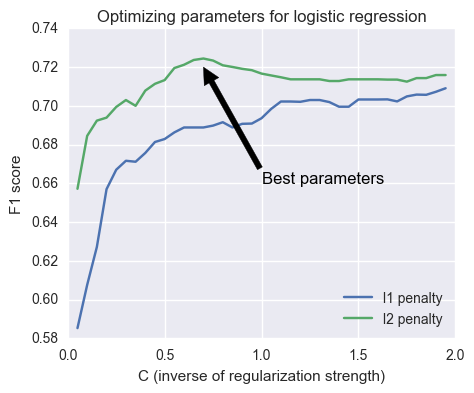

In [9]:
# Create array indicating when each penalty parameter was used during grid search
param_penalty = grid_lr.cv_results_['param_penalty']

# Create two arrays storing cross-validated F1-scores associated with each penalty type
mean_test_score_l1 = np.array(grid_lr.cv_results_['mean_test_score'][param_penalty == 'l1'])
mean_test_score_l2 = np.array(grid_lr.cv_results_['mean_test_score'][param_penalty == 'l2'])

# Create two arrays storing C parameters associated with each penalty type
param_C_l1 = np.array(grid_lr.cv_results_['param_C'][param_penalty == 'l1'])
param_C_l2 = np.array(grid_lr.cv_results_['param_C'][param_penalty == 'l2'])

# Plot cross-validated F1-score as function of C parameter for both l1 and l2 penalties
plt.figure(figsize = (5,4))
plt.plot(param_C_l1, mean_test_score_l1)
plt.plot(param_C_l2, mean_test_score_l2)
plt.legend(['l1 penalty','l2 penalty'], loc = 4)
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('F1 score')
plt.title('Optimizing parameters for logistic regression')
plt.annotate('Best parameters', xy = (0.7, 0.72), xytext = (1, .66),
             arrowprops=dict(facecolor='black'), color='black')
plt.show()

### Adaboost

In [10]:
# Define adaptive boosting hyperparameter ranges to be tested using grid search
x = np.arange(30,110,10)
y = np.arange(0.5,2.25,0.25)
param_grid_ada = [{'n_estimators': x,'learning_rate': y}]

# Conduct grid search for adaptive boosting hyperparameters
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid_ada, 'f1', cv = 5)
grid_ada.fit(X_train_ada_, y_train)

# Print results and create an adaptive boosting model with chosen hyperparameters
print('Best parameters:',grid_ada.best_params_)
print('Best score:', grid_ada.best_score_)
ada = grid_ada.best_estimator_

Best parameters: {'n_estimators': 70, 'learning_rate': 1.0}
Best score: 0.669780910862


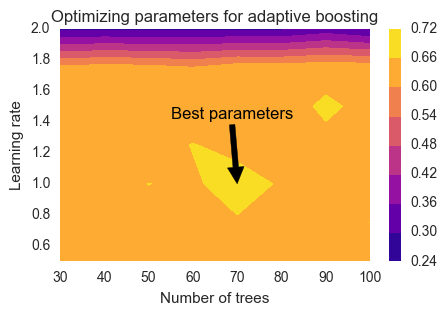

In [19]:
# Plot cross-validated F1-score as function of learning rate and number of trees
z = grid_ada.cv_results_['mean_test_score'].reshape(len(y),len(x))

plt.figure(figsize = (5,3))
g = plt.contourf(x, y, z, cmap='plasma')
plt.colorbar(g)
plt.grid(True)
plt.ylim(0.5,2.0)
plt.title('Optimizing parameters for adaptive boosting')
plt.xlabel('Number of trees')
plt.ylabel('Learning rate')
plt.annotate('Best parameters', xy = (70, 1), xytext = (55, 1.42), arrowprops = {'facecolor':'black'},
             color = 'black')
plt.show()

### Bernoulli naive bayes

In [20]:
# Define naive bayes hyperparameter ranges to be tested using grid search
param_grid_bnb = [{'alpha': np.arange(0, 2.1, 0.1)}]

# Conduct grid search for naive bayes hyperparameters
grid_bnb = GridSearchCV(BernoulliNB(), param_grid_bnb, 'f1', cv = 5)
grid_bnb.fit(X_train_bnb_, y_train)

# Print results and create an naive bayes model with chosen hyperparameters
print('Best parameters:',grid_bnb.best_params_)
print('Best score:', grid_bnb.best_score_)
bnb = grid_bnb.best_estimator_

Best parameters: {'alpha': 0.10000000000000001}
Best score: 0.695052807359


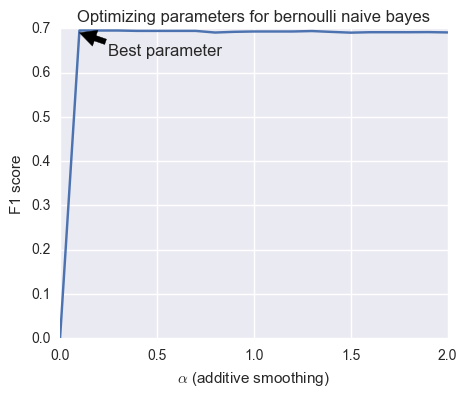

In [24]:
x = np.arange(0, 2.1, 0.1)
y = grid_bnb.cv_results_['mean_test_score']

plt.figure(figsize = (5,4))
plt.plot(x, y)
plt.title('Optimizing parameters for bernoulli naive bayes')
plt.ylabel('F1 score')
plt.xlabel(r'$\alpha$ (additive smoothing)')
plt.annotate('Best parameter', xy = (0.1, 0.69), xytext = (0.25, 0.64), arrowprops = {'facecolor':'black'})
plt.show()

### Support vector machine

In [48]:
# Define SVM hyperparameter ranges to be tested using grid search
x = np.arange(1.5,3.7,0.2)
y = 1 / (len(X_train_svm) * np.arange(0.015, 0.045, 0.002))
param_grid_svm = [{'C': x, 'gamma': y}]

# Conduct grid search for SVM hyperparameters
grid_svm = GridSearchCV(SVC(), param_grid_svm, 'f1', cv = 3)
grid_svm.fit(X_train_svm_, y_train)

# Print results and create an SVM model with chosen hyperparameters
print('Best parameters:',grid_svm.best_params_)
print('Best score:', grid_svm.best_score_)
svm = grid_svm.best_estimator_

Best parameters: {'gamma': 0.016015374759769371, 'C': 3.2999999999999998}
Best score: 0.655275707072


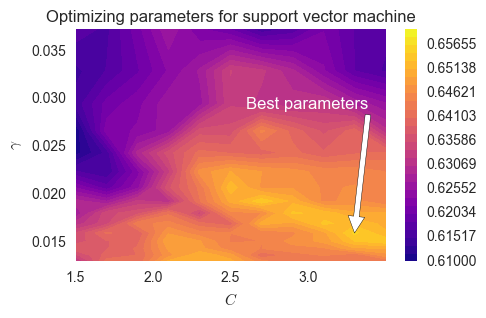

In [57]:
z = grid_svm.cv_results_['mean_test_score'].reshape(len(x),len(y))

plt.figure(figsize = (5,3))
g = plt.contourf(x, y, z.T, cmap='plasma', levels = np.linspace(0.61,0.66,30))
plt.colorbar(g)
plt.grid(True)
plt.title('Optimizing parameters for support vector machine')
plt.xlabel('$C$')
plt.ylabel(r'$\gamma$')
plt.annotate('Best parameters', xy = (3.3,.016), xytext = (2.6, .029), arrowprops = {'facecolor':'white'},
             color = 'white')
plt.show()

# Evaluating individual classifiers

In [58]:
def evaluate_test(y_test, y_pred, threshold = 0.5, name = 'estimator', show_curve = True):
    
    #Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred[:,1] > threshold)
    precision = precision_score(y_test, y_pred[:,1] > threshold)
    recall = recall_score(y_test, y_pred[:,1] > threshold)
    f1 = f1_score(y_test, y_pred[:,1] > threshold)
    roc = roc_auc_score(y_test, y_pred[:,1])
    
    #Print performance metrics
    print('Accuracy:', accuracy, ', Precision:', precision, ', Recall:', recall)
    print('F1 score:', f1, ', ROC area:', roc)
    print('Confusion matrix:\n',confusion_matrix(y_test, y_pred[:,1] > threshold))
    
    #Plot ROC curve
    if show_curve:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        plt.figure(figsize = (5,4))
        plt.plot(fpr, tpr)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve for {}'.format(name))
        plt.show()
        
    return [accuracy, precision, recall, f1, roc]

In [59]:
def find_best_threshold(X_train, y_train, preprocessing, estimator, name = 'estimator',
                        threshold_list = np.arange(0, 1.01, .01), show_curve = True):
    
    # Train estimator and generate array of prediction probabilities
    X_train = preprocessing.fit_transform(X_train)
    estimator.fit(X_train,y_train)
    y_pred = estimator.predict_proba(X_train)
    
    # Generate array of F1-scores as function of thresholds and prints threshold that yields highest F1-score
    f1_list = []
    best_threshold = 0
    best_f1 = 0
    for threshold in threshold_list:
        f1 = f1_score(y_train, y_pred[:,1] > threshold)
        f1_list.append(f1)
        if f1 > best_f1:
            best_threshold = threshold
            best_f1 = f1
    print('Best threshold:', best_threshold, ', Best F1:', best_f1)
    
    # Plot F1-score as function of threshold
    if show_curve:
        plt.figure(figsize = (5,4))
        plt.plot(threshold_list, f1_list)
        plt.xlabel('Threshold')
        plt.ylabel('F1 score')
        plt.title('Optimizing threshold for {}'.format(name))
        plt.show()     
    return best_threshold

### Logistic regression

Best threshold: 0.38 , Best F1: 0.771573604061


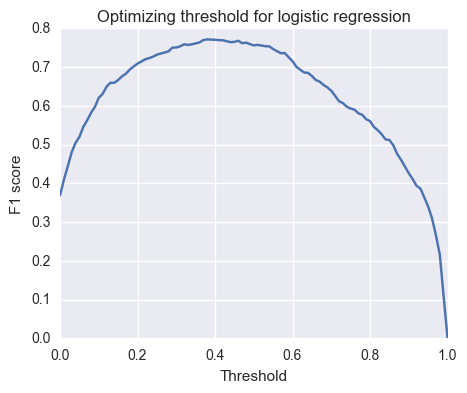

In [60]:
threshold_lr = find_best_threshold(X_train_lr, y_train, preprocessing, lr, 'logistic regression')

Accuracy: 0.782588011418 , Precision: 0.530701754386 , Recall: 0.72745490982
F1 score: 0.613693998309 , ROC area: 0.849254341496
Confusion matrix:
 [[1282  321]
 [ 136  363]]


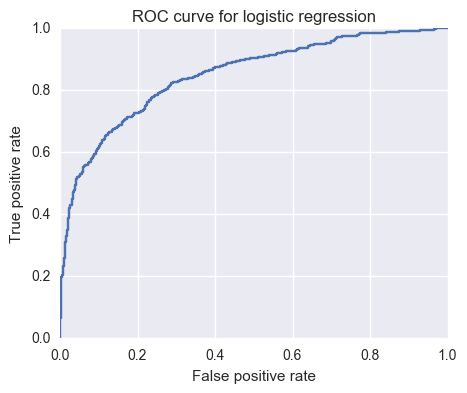

In [61]:
lr.fit(preprocessing.fit_transform(X_train_lr),y_train)
y_pred_lr = lr.predict_proba(preprocessing.transform(X_test_lr))
scores_lr = evaluate_test(y_test, y_pred_lr, threshold_lr, 'logistic regression', True)

### Adaptive boosting

Best threshold: 0.497 , Best F1: 0.735849056604


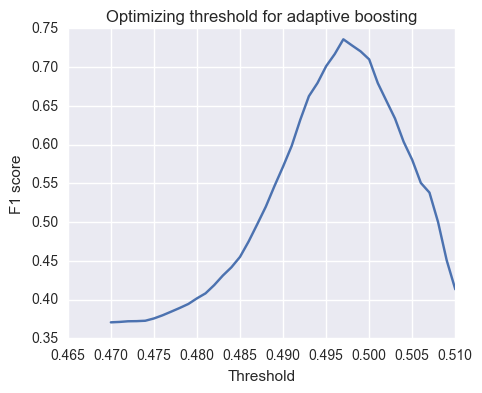

In [62]:
threshold_ada = find_best_threshold(X_train_ada, y_train, preprocessing, ada, 'adaptive boosting',
                                    np.arange(.47, .51, .001), True)

Accuracy: 0.794005708849 , Precision: 0.552215189873 , Recall: 0.699398797595
F1 score: 0.617152961981 , ROC area: 0.833284160336
Confusion matrix:
 [[1320  283]
 [ 150  349]]


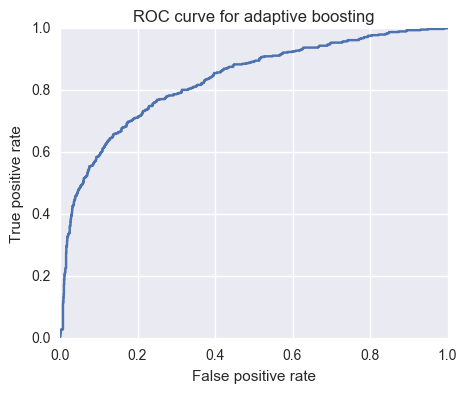

In [63]:
ada.fit(preprocessing.fit_transform(X_train_ada),y_train)
y_pred_ada = ada.predict_proba(preprocessing.transform(X_test_ada))
scores_ada = evaluate_test(y_test, y_pred_ada, threshold_ada, 'adaptive boosting', True)

### Bernoulli naive bayes

Best threshold: 0.276 , Best F1: 0.72247706422


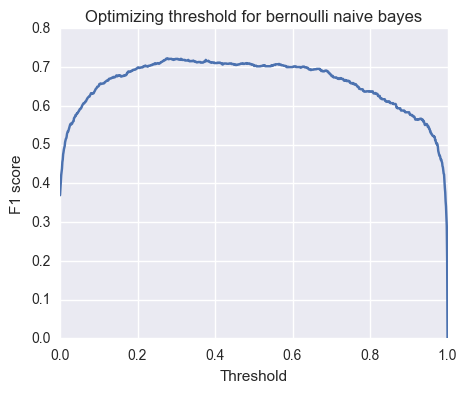

In [64]:
threshold_bnb = find_best_threshold(X_train_bnb, y_train, preprocessing, bnb, 'bernoulli naive bayes',
                                    np.arange(0, 1.001, .001), True)

Accuracy: 0.77973358706 , Precision: 0.525280898876 , Recall: 0.749498997996
F1 score: 0.617671345995 , ROC area: 0.843036665971
Confusion matrix:
 [[1265  338]
 [ 125  374]]


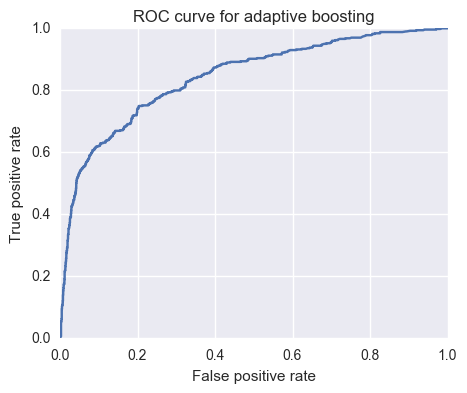

In [65]:
bnb.fit(preprocessing.fit_transform(X_train_bnb),y_train)
y_pred_bnb = bnb.predict_proba(preprocessing.transform(X_test_bnb))
scores_bnb = evaluate_test(y_test, y_pred_bnb, threshold_bnb, 'adaptive boosting', True)

Given that the training F1-score for the Bernoulli naive bayes classifier, at **0.665**, is lower than that of both logistic regression and adaptive boosting, it is not a great surprise that the test F1-score, at **0.538**, is also lower than the previous two classifiers. Whereas adaptive boosting has a tendency to misclassify voters as non-voters, the naive bayes classifier appears to have the opposite problem of consistently misclassifying non-voters as voters.

### Support vector machine

Best threshold: 0.262 , Best F1: 0.894031668697


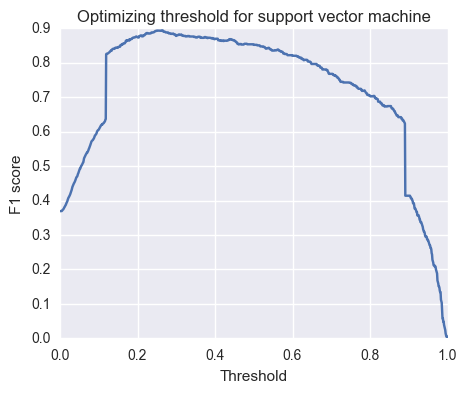

In [66]:
svm.probability = True
threshold_svm = find_best_threshold(X_train_svm, y_train, preprocessing, svm, 'support vector machine',
                                    np.arange(0, 1.001, .001), True)

Accuracy: 0.775451950523 , Precision: 0.518367346939 , Recall: 0.763527054108
F1 score: 0.617504051864 , ROC area: 0.847816656395
Confusion matrix:
 [[1249  354]
 [ 118  381]]


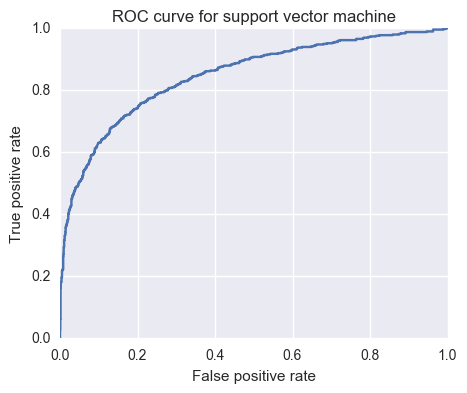

In [67]:
svm.fit(preprocessing.fit_transform(X_train_svm),y_train)
y_pred_svm = svm.predict_proba(preprocessing.transform(X_test_svm))
scores_svm = evaluate_test(y_test, y_pred_svm, threshold_svm, 'support vector machine', True)

### Summary of results for individual classifiers

In [68]:
scores_lr = pd.DataFrame(scores_lr)
scores_ada = pd.DataFrame(scores_ada)
scores_bnb = pd.DataFrame(scores_bnb)
scores_svm = pd.DataFrame(scores_svm)
scores = pd.concat([scores_lr, scores_ada, scores_bnb, scores_svm], axis = 1).T
scores.columns = ['Accuracy','Precision','Recall','F1 score','ROC area']
scores.index = ['Logistic regression','Adaptive boosting','Bernoulli naive bayes','Support vector machine']
scores

,Accuracy,Precision,Recall,F1 score,ROC area
Logistic regression,0.782588,0.530702,0.727455,0.613694,0.849254
Adaptive boosting,0.794006,0.552215,0.699399,0.617153,0.833284
Bernoulli naive bayes,0.779734,0.525281,0.749499,0.617671,0.843037
Support vector machine,0.775452,0.518367,0.763527,0.617504,0.847817


In [69]:
intend_nv_train = sum(df_orig.loc[df_orig.year < 2008,'VCF0713_oh4']) / len(df_orig[df_orig.year < 2008])
intend_nv_test = sum(df_orig.loc[df_orig.year == 2008,'VCF0713_oh4']) / len(df_orig[df_orig.year == 2008])
actual_nv_train = len(df_orig.loc[(df_orig.year < 2008) & (df_orig.final_vote == 0)]) / \
    len(df_orig[df_orig.year < 2008])
actual_nv_test = len(df_orig.loc[(df_orig.year == 2008) & (df_orig.final_vote == 0)]) / \
    len(df_orig[df_orig.year == 2008])
nv_table = np.array([[intend_nv_train, actual_nv_train],
                    [intend_nv_test, actual_nv_test]])
nv_table = pd.DataFrame(nv_table, columns = ['Proportion intended non-vote','Proportion actual non-vote'],
                        index = ['Training data (pre-2008)','Test data (2008)'])
nv_table

,Proportion intended non-vote,Proportion actual non-vote
Training data (pre-2008),0.108744,0.253924
Test data (2008),0.124167,0.267840


# Soft voting classifier (part 1)

In [70]:
class SoftVotingClassifier:
    def __init__(self, estimators, print_cv = True):
        self.estimators = estimators
        self.n = len(estimators)
        self.blending = BaggingClassifier(LogisticRegression(), n_estimators = 20)
        self.print_cv = print_cv
        
    def fit(self, X_train_list, y_train):
        assert(self.n == len(X_train_list))
        predict_probas = np.zeros([len(y_train), self.n])
        for i in range(0, self.n):
            self.estimators[i].fit(X_train_list[i], y_train)
            predict_probas[:,i] = self.estimators[i].predict_proba(X_train_list[i])[:,1]
            
        self.blending.fit(predict_probas, y_train)
        y_pred = self.blending.predict_proba(predict_probas)[:,1]
        
        accuracy_cv = cross_val_score(self.blending, predict_probas, y_train, cv = 5, scoring = 'accuracy')
        print('Cross-validated accuracy:', accuracy_cv.mean())
        f1_cv = cross_val_score(self.blending, predict_probas, y_train, cv = 5, scoring = 'f1')
        print('Cross-validated f1:', f1_cv.mean())
        
        return y_pred
    
    def predict_proba(self, X_test_list):
        assert(self.n == len(X_train_list))
        predict_probas = np.zeros([len(y_test), self.n])
        for i in range(0, self.n):
            predict_probas[:,i] = self.estimators[i].predict_proba(X_test_list[i])[:,1]
        
        y_pred = self.blending.predict_proba(predict_probas)[:,1]
        
        return y_pred

In [71]:
classifiers = [lr,ada,bnb,svm]
voting = SoftVotingClassifier(classifiers)
X_train_list = [X_train_lr, X_train_ada, X_train_bnb, X_train_svm]
X_test_list = [X_test_lr, X_test_ada, X_test_bnb, X_test_svm]
norm = Normalizer()
for i in range(0, len(X_train_list)):
    X_train_list[i] = imp.fit_transform(X_train_list[i])
    X_train_list[i] = norm.fit_transform(X_train_list[i])
    X_test_list[i] = imp.transform(X_test_list[i])
    X_test_list[i] = norm.transform(X_test_list[i])
y_pred = voting.fit(X_train_list, y_train)

Cross-validated accuracy: 0.942827243257
Cross-validated f1: 0.865820738456


We see that the accuracy and F1-score of the custom soft voting classifier is pretty good on the training data, though it performs only marginally better than using a support vector machine at a threshold of **0.5**.

Best threshold: 0.2 , Best F1: 0.894348894349


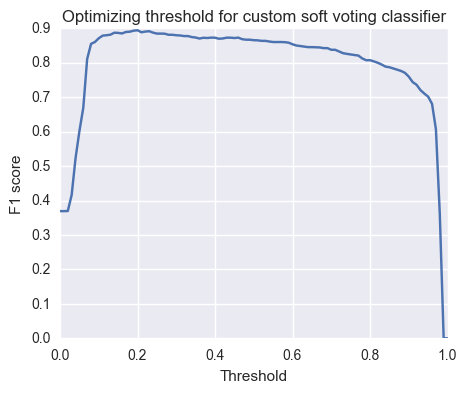

In [72]:
f1_list = []
best_threshold = 0
best_f1 = 0
for threshold in np.arange(0,1.01,0.01):
    f1 = f1_score(y_train, y_pred > threshold)
    f1_list.append(f1)
    if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1
print('Best threshold:', best_threshold, ', Best F1:', best_f1)
plt.figure(figsize = (5,4))
plt.plot(np.arange(0,1.01,0.01), f1_list)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('Optimizing threshold for custom soft voting classifier')
plt.show()  

In [73]:
y_test_pred = voting.predict_proba(X_test_list)

In [74]:
print('Test accuracy:', accuracy_score(y_test, y_test_pred > 0.2))
print('Test f1-score:', f1_score(y_test, y_test_pred > 0.2))
print('Test confusion matrix:\n', confusion_matrix(y_test, y_test_pred > 0.2))

Test accuracy: 0.782112274025
Test f1-score: 0.625204582651
Test confusion matrix:
 [[1262  341]
 [ 117  382]]


Furthermore, we see that optimizing the threshold using the predicted probabilites of training data does not work particularly well, resulting in very poor performance both in terms of accuracy and F1.

Best threshold: 0.63 , Best F1: 0.641237113402


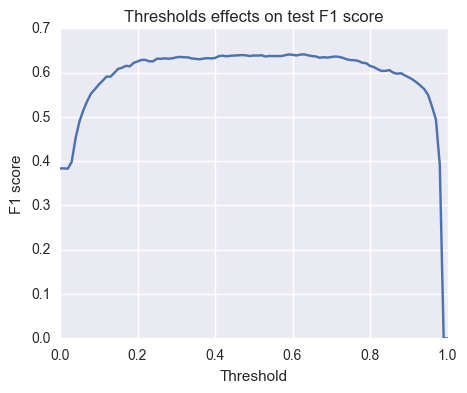

In [75]:
f1_list = []
best_threshold = 0
best_f1 = 0
for threshold in np.arange(0,1.01,0.01):
    f1 = f1_score(y_test, y_test_pred > threshold)
    f1_list.append(f1)
    if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1
print('Best threshold:', best_threshold, ', Best F1:', best_f1)
plt.figure(figsize = (5,4))
plt.plot(np.arange(0,1.01,0.01), f1_list)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('Thresholds effects on test F1 score')
plt.show()  

# Soft voting classifier (part 2)

In [76]:
best_score = 0
best_weights = None

weight_combos = itertools.product([1,2,3,4],[1,2],[1,2],[1,2,3])
for weights in weight_combos:
    voting = VotingClassifier([('lr',lr,),('ada',ada), ('bnb',bnb), ('svc',svm)], voting = 'soft',
                              weights = weights)
    X_train_vote = preprocessing.fit_transform(X_train_lr)
    voting.fit(X_train_vote, y_train)
    y_vote_pred = voting.predict(X_train_vote)
    score = f1_score(y_train, y_vote_pred)
    print('{} -> f1 score: {}'.format(weights, score))
    if score > best_score:
        best_score = score
        best_weights = weights

print('Best f1:', best_score)
print('Best weights:', best_weights)

(1, 1, 1, 1) -> f1 score: 0.7526315789473684
(1, 1, 1, 2) -> f1 score: 0.7606019151846786
(1, 1, 1, 3) -> f1 score: 0.7634854771784232
(1, 1, 2, 1) -> f1 score: 0.7304785894206549
(1, 1, 2, 2) -> f1 score: 0.7425614489003882
(1, 1, 2, 3) -> f1 score: 0.7546666666666667
(1, 2, 1, 1) -> f1 score: 0.7526315789473684
(1, 2, 1, 2) -> f1 score: 0.762550881953867
(1, 2, 1, 3) -> f1 score: 0.7634854771784232
(1, 2, 2, 1) -> f1 score: 0.7304785894206549
(1, 2, 2, 2) -> f1 score: 0.7458064516129033
(1, 2, 2, 3) -> f1 score: 0.7533512064343164
(2, 1, 1, 1) -> f1 score: 0.7638326585695007
(2, 1, 1, 2) -> f1 score: 0.7524204702627939
(2, 1, 1, 3) -> f1 score: 0.756606397774687
(2, 1, 2, 1) -> f1 score: 0.7396907216494846
(2, 1, 2, 2) -> f1 score: 0.7526315789473684
(2, 1, 2, 3) -> f1 score: 0.7615176151761518
(2, 2, 1, 1) -> f1 score: 0.765498652291105
(2, 2, 1, 2) -> f1 score: 0.7592847317744154
(2, 2, 1, 3) -> f1 score: 0.756606397774687
(2, 2, 2, 1) -> f1 score: 0.7396907216494846
(2, 2, 2, 2) -

In [77]:
voting = VotingClassifier([('lr',lr,),('ada',ada), ('bnb',bnb), ('svc',svm)], voting = 'soft',
                              weights = best_weights)

X_train_vote = preprocessing.fit_transform(X_train_lr)
voting.fit(X_train_vote, y_train)
y_vote_pred = voting.predict_proba(X_train_vote)

Best threshold: 0.5 , Best F1: 0.765498652291


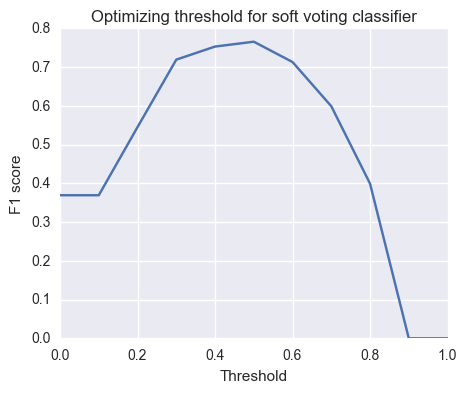

In [78]:
f1_list = []
best_threshold = 0
best_f1 = 0
for threshold in np.arange(0,1.1,0.1):
    f1 = f1_score(y_train, y_vote_pred[:,1] > threshold)
    f1_list.append(f1)
    if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1
print('Best threshold:', best_threshold, ', Best F1:', best_f1)
plt.figure(figsize = (5,4))
plt.plot(np.arange(0,1.1,0.1), f1_list)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('Optimizing threshold for soft voting classifier')
plt.show()  

In [79]:
X_test_vote = preprocessing.fit_transform(X_test_lr)
y_vote_pred_test = voting.predict_proba(X_test_vote)
print('Test f1-score:', f1_score(y_test, y_vote_pred_test[:,1] > 0.5))
print('Test confusion matrix:\n', confusion_matrix(y_test, y_vote_pred_test[:,1] > 0.5))

Test f1-score: 0.646718146718
Test confusion matrix:
 [[1401  202]
 [ 164  335]]


In [80]:
with open('../data/predictions_train_2008b.pkl','wb') as output:
    pkl.dump(y_vote_pred[:,1], output)
with open('../data/predictions_test_2008b.pkl','wb') as output:
    pkl.dump(y_vote_pred_test[:,1], output)